In [25]:
import dnnlib
import legacy
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.interpolate
import math
import random
import preprocessing.image_utils as itools
import cv2
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
network_pkl = "../t-golden-fid14.19.pkl"
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
print("Network loaded.")

Loading networks from "../t-golden-fid14.19.pkl"...
Network loaded.


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
torch.Size([1, 3, 1024, 1024])


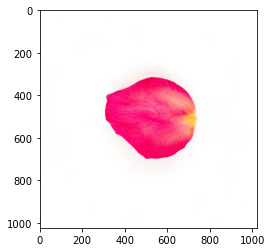

In [8]:
def make_transform(translate, angle):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

def synthesize_image(z, translate=(0,0), rotate=0, noise_mode = "const", truncation_psi = 1):
    label = torch.zeros([1, G.c_dim], device=device)
    # Construct an inverse rotation/translation matrix and pass to the generator.  The
    # generator expects this matrix as an inverse to avoid potentially failing numerical
    # operations in the network.
    if hasattr(G.synthesis, 'input'):
        m = make_transform(translate, rotate)
        m = np.linalg.inv(m)
        G.synthesis.input.transform.copy_(torch.from_numpy(m))

    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    print(img.shape)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
#     PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')

def synthesize_rand_image(seed):
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    return synthesize_image(z)

# 9 
# 13
# 16
# 20
# 21
# 25
# 27
# 28
# 31
# 34
# 37
# 38
# 39
# 43
# 49
# 50
# 400
img = synthesize_rand_image(50)
plt.imshow(img)

In [89]:
def find_smallest_bbox(img, bbox):
    img_height, img_width, _channels = img.shape
    x, y, w, h = bbox
    diff = w - h
    if diff > 0:
        y = y - diff // 2
        h = w
    elif diff < 0:
        x = x + diff // 2
        w = h
    if w != h:
        raise ("BBOX IS NOT SQUARE!")
    return x, y, w, h

def crop_to_smallest_bbox(img):
#     contrast = itools.contrast(img, (3, 8))
#     img = np.array(img) 
#     # Convert RGB to BGR 
#     img = open_cv_image[:, :, ::-1].copy()
    
    sat = itools.saturate(img, 5)
    gray = itools.threshold(sat, 210)
    contour = itools.find_largest_contour(gray)

    if contour is None:
        raise "NO CONTOUR"

    # get the bounding box
    bbox = cv2.boundingRect(contour)

    # delete if there is no bounding box
    if bbox is None:
        raise "NO BBOX FOUND"

    crop = find_smallest_bbox(img, bbox)
#     if crop is None:
#         raise "NO CROP FOUND"

    cropped = itools.crop(img, crop)
    return cropped

In [9]:
z = torch.from_numpy(np.random.RandomState(1).randn(G.z_dim)).to(device)
print("z.shape, G.z_dim", z.shape, G.z_dim)


# testing
a = np.array([[1, 2, 3], [4, 5, 6]])
t = np.tile(a, [2])
print("a.shape, t.shape", a.shape, t.shape)

z.shape, G.z_dim torch.Size([512]) 512
a.shape, t.shape (2, 3) (2, 6)


In [176]:
def synthesize_rand_interp(seeds, w_frames = 20):
    print("interpolating: ", seeds)
#     num_keyframes = 100
    num_keyframes = len(seeds) // 1
    wraps = 1
    kind= "cubic"
    imgs = []
#     w_frames=60*4
    
    zs = torch.from_numpy(np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in seeds])).to(device)
    ws = G.mapping(z=zs, c=None, truncation_psi=1)
    _ = G.synthesis(ws[:1]) # warm up
    print("ws.shape original", ws.shape)
    print("ws[:1].shape", ws.shape[:1])
    ws = ws.reshape(1, 1, num_keyframes, *ws.shape[1:])
    print("ws.shape", ws.shape)
    
    # wraps = 0
    # ws.shape torch.Size([1, 1, 2, 16, 512])
    # x.shape, y.shape (2,) (2, 16, 512)
    
    # wrapping back to the original
#     x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
#     y = np.tile(ws[0][0].cpu().numpy(), [wraps * 2 + 1, 1, 1])
    
    x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
    y = np.tile(ws[0][0].cpu().numpy(), [wraps * 2 + 1, 1, 1])

#     x = np.arange(0, 2)
#     y = np.tile(ws[0][0].cpu().numpy(), [1, 1, 1])
    print("x.shape, y.shape", x.shape, y.shape)
    interp = scipy.interpolate.interp1d(x, y, kind=kind, axis=0)
    
    for frame_idx in tqdm(range(num_keyframes * w_frames)):
        w = torch.from_numpy(interp(frame_idx / w_frames)).to(device)
        img = G.synthesis(ws=w.unsqueeze(0), noise_mode='const')[0]
        img = img.reshape(1, 3, 1024, 1024)
        img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#         img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = img.permute(0, 2, 3, 1)
        img = img[0].cpu().numpy() # PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
        imgs.append(img)
    
    return imgs
    
imgs = synthesize_rand_interp([9, 300, 32])

interpolating:  [9, 300, 32]
ws.shape original torch.Size([3, 16, 512])
ws[:1].shape torch.Size([3])
ws.shape torch.Size([1, 1, 3, 16, 512])
x.shape, y.shape (9,) (9, 16, 512)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.70it/s]


images 60


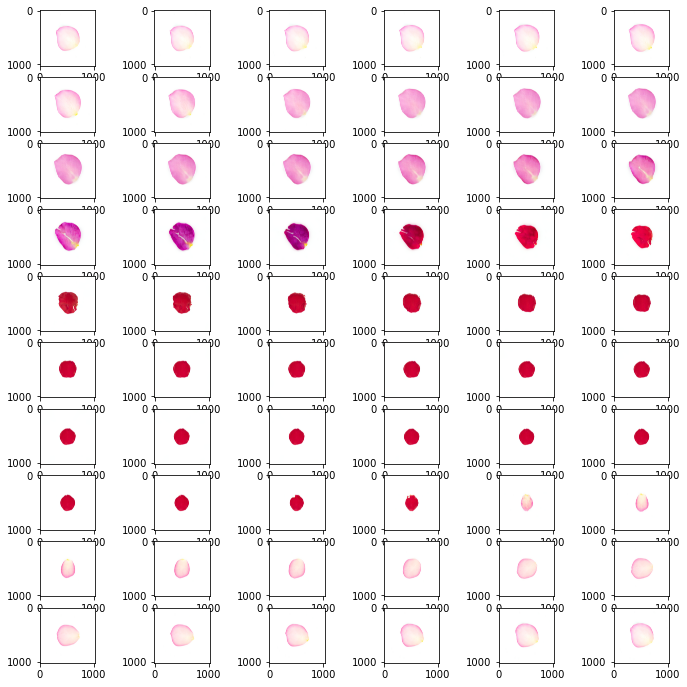

In [177]:
# plt.imshow(imgs[2])
# # plt.imshow(imgs[1])
print("images", len(imgs))
cols = min(len(imgs), 6)
rows = max(math.ceil(len(imgs) / cols), 1)
_, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

[5663, 9054, 636, 6441]
images: 60 uint8
out.shape (119, 119, 302, 302, 3) uint8
resized.shape (35938, 35938, 3)


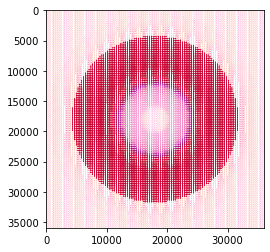

In [178]:
def synthesize_kaleidoscope(num_seeds = 4, w_frames = 20):
    seeds = [random.randint(1, 10000) for i in range(num_seeds)]
    print(seeds)
    
    # crop to bbox
    cropped_imgs = []
    for img in imgs:
        cropped = crop_to_smallest_bbox(img)
        cropped_imgs.append(cropped)
    # normalize size
    size = None
    for img in cropped_imgs:
        if size is None or img.shape[0] < size:
            size = img.shape[0]
    resized_imgs = []
    for img in cropped_imgs:
        pil = PIL.Image.fromarray(img, 'RGB')
        resized = pil.resize((size, size), resample=PIL.Image.BICUBIC)
        resized_imgs.append(np.array(resized))
    
    count = len(imgs) 
    dims = count * 2 - 1
    r = dims // 2
    # construct output
    out = np.zeros((dims, dims, size, size, 3)).astype(np.uint8) 
    out2 = np.zeros((dims * size, dims * size, 3)).astype(np.uint8)
    print("images:", count, resized_imgs[0].dtype)
    test = []
    for row in range(dims):
        for col in range(dims):
            x = col - r
            y = r - row
            l = round(math.sqrt(x ** 2 + y ** 2))
            out[col, row] = resized_imgs[min(l, count - 1)]
            out2[col * size: (col+1)* size, row * size: (row+1)* size] = resized_imgs[min(l, count - 1)]
            test.append(resized_imgs[min(l, count - 1)])
    
    print("out.shape", out.shape, out.dtype)
    final = out.reshape((dims * size, dims * size, 3))
    print("resized.shape", final.shape)
    return out2
        
    

resized = synthesize_kaleidoscope()
plt.imshow(resized)
